# Benchmarking & Evaluation
The purpose of this notebook is to benchmark our implemented models against each other, as well as against other open source inpainting implementations

In [ ]:
import os
from copy import deepcopy

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf

from libs.data_loaders import AugmentingDataGenerator
from libs.unet_model import InpaintingUnet
from libs.util import MaskGenerator


%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TEST_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/test"
MASK_DIR = r"./data/masks/test"
BATCH_SIZE = 1

# Utility Functions
Utility functions for evaluating models

In [2]:
# Instantiate mask generator with preset masks
mask_generator = MaskGenerator(
    512, 512, 3, rand_seed=42, filepath=MASK_DIR, rotation=False, dilation=False, cropping=False, invert=False
)

# Create testing generator
test_datagen = AugmentingDataGenerator(mask_generator, rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

def evaluate_model(model, tests_per_image=5):
    
    metric_maskratio = []
    metric_psnr = []
    metric_ssim = []
    metric_l1 = []
    
    mae = tf.keras.losses.MeanAbsoluteError()
    
    # Loop through test masks released with paper
    test_masks = os.listdir(MASK_DIR)
    for i, filename in tqdm(enumerate(test_masks), total=len(test_masks)):

        # Load mask from paper
        filepath = os.path.join('./data/masks/test', filename)
        mask = cv2.imread(filepath) / 255        
        maskratio = mask[:,:,0].sum() / (512 * 512)
        mask = np.array([1-mask for _ in range(BATCH_SIZE)])        
        
        for _ in range(tests_per_image):

            # Pick out image from test generator
            test_data = next(test_generator)
            (_, _), ori = test_data

            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Run prediction on image & mask
            pred = model.predict([ori, mask])

            # Add metrics
            metric_maskratio.append(maskratio)
            metric_psnr.append(tf.image.psnr(ori, pred, max_val=1).numpy()[0])
            metric_ssim.append(tf.image.ssim(ori, pred, max_val=1).numpy()[0])
            metric_l1.append(mae(ori, pred).numpy())   
        
        if i > 50:
            break
            
    return pd.DataFrame({
        'maskratio': metric_maskratio,
        'psnr': metric_psnr,
        'ssim': metric_ssim,
        'l1': metric_l1
    })

>> Found 12000 masks in ./data/masks/test
Found 99943 images belonging to 1 classes.


# Evalulate PConv Network
Liu *et al.*,  **Image Inpainting for Irregular Holes Using Partial Convolutions**, https://arxiv.org/abs/1804.07723

In [3]:
model = InpaintingUnet(
    conv_layer='pconv', 
    load_weights='./data/logs/imagenet_phase1/weights.01-35.29'
)

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

  0%|          | 51/12000 [00:42<2:45:07,  1.21it/s]


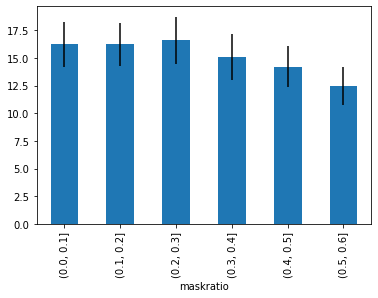

In [35]:
df = evaluate_model(model)

means = df.groupby(pd.cut(df.maskratio, np.linspace(0, 0.6, 7))).psnr.mean()
stds = df.groupby(pd.cut(df.maskratio, np.linspace(0, 0.6, 7))).psnr.std()

means.plot(yerr=stds, kind='bar')
plt.show()

# Evaluate GConv Network
Architecture from: * Liu *et al.*,  **Image Inpainting for Irregular Holes Using Partial Convolutions**, https://arxiv.org/abs/1804.07723

Conv Layer from : Yu *et al.*,  **Free-Form Image Inpainting with Gated Convolution**, https://arxiv.org/abs/1806.03589

In [ ]:
model = InpaintingUnet(
    conv_layer='gconv', 
    load_weights='./data/logs/imagenet_phase1/weights.01-35.29'
)

# Co-mod-GAN
Source: Zhao *et al.*, Large Scale Image Completion Via Co-Modulated Generative Adversarial Networks, https://openreview.net/pdf?id=sSjqmfsk95O